# Predict mel-cepstrum parameters

In [3]:
import numpy as np
import h5py
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, Adadelta
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Model

In [41]:
hidden_layers = 6

In [91]:
nlayers=1024
model = Sequential()
model.add(Dense(nlayers, input_dim=215, activation='tanh', init = 'glorot_normal'))
model.add(Dropout(0.5))
for i in range(0,hidden_layers):
    model.add(Dense(nlayers, activation='tanh',init = 'glorot_normal'))
    model.add(Dropout(0.5))
model.add(Dense(26, activation='sigmoid'))

model.summary()        

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_21 (Dense)                 (None, 1024)          221184      dense_input_4[0][0]              
____________________________________________________________________________________________________
dropout_18 (Dropout)             (None, 1024)          0           dense_21[0][0]                   
____________________________________________________________________________________________________
dense_22 (Dense)                 (None, 1024)          1049600     dropout_18[0][0]                 
____________________________________________________________________________________________________
dropout_19 (Dropout)             (None, 1024)          0           dense_22[0][0]                   
___________________________________________________________________________________________

In [92]:
early_stopping = EarlyStopping(patience=8)

In [93]:
model.compile(optimizer=SGD(lr=0.1, momentum=0.6, nesterov=False), loss='mse', metrics=['accuracy'])

### Data import

In [46]:
data = []
with h5py.File('preprocessed_data/train-standardized.h5','r') as hf:
    data = np.array(hf.get('dataset'))
input_data = data[:,0:215]
print(input_data.shape)
target_data = data[:,216:242]
target_data = target_data
print(target_data.shape)

(216559, 215)
(216559, 26)


In [47]:
maxs = np.max(target_data, axis=0)
mins = np.min(target_data, axis=0)
target_data = (target_data-mins)/(maxs-mins)

In [48]:
target_data[0]

array([ 0.73814645,  0.76527393,  0.47790412,  0.33882775,  0.4489624 ,
        0.48961343,  0.36189146,  0.62252821,  0.39055215,  0.24699535,
        0.46588663,  0.6678122 ,  0.37303752,  0.52430356,  0.46628601,
        0.50978467,  0.43729774,  0.60958709,  0.46097176,  0.54965794,
        0.32055403,  0.48964431,  0.38241332,  0.4390129 ,  0.49702345,
        0.35178929])

Validation

In [5]:
data_validation = []
with h5py.File('preprocessed_data/validation.h5','r') as hf:
    data_validation = np.array(hf.get('dataset'))
input_validation = data_validation[:,0:215]
print(input_validation.shape)
target_validation = data_validation[:,216:242]
target_validation = target_validation
print(target_validation.shape)

(12594, 215)
(12594, 26)


In [4]:
mean = []
with h5py.File('preprocessed_data/train-mean.h5') as hf:
    mean = np.array(hf.get('dataset'))
sdt = []
with h5py.File('preprocessed_data/train-mean.h5') as hf:
    std = np.array(hf.get('dataset'))

In [51]:
input_validation2 = (input_validation-mean[0:215])/(std[0:215])

In [52]:
target_validation = (target_validation-mins)/(maxs-mins)

## Train

In [94]:
model.fit(input_data, target_data, nb_epoch=1000, 
          validation_data=(input_validation2, target_validation),batch_size=1024, verbose=1,
         callbacks=[early_stopping])

Train on 216559 samples, validate on 12594 samples
Epoch 1/1000
216559/216559 [==============================] - 7s - loss: 0.0543 - acc: 0.0539 - val_loss: 0.0194 - val_acc: 0.1381
Epoch 2/1000
216559/216559 [==============================] - 7s - loss: 0.0461 - acc: 0.0845 - val_loss: 0.0170 - val_acc: 0.1977
Epoch 3/1000
216559/216559 [==============================] - 7s - loss: 0.0408 - acc: 0.1037 - val_loss: 0.0159 - val_acc: 0.2161
Epoch 4/1000
216559/216559 [==============================] - 7s - loss: 0.0368 - acc: 0.1144 - val_loss: 0.0152 - val_acc: 0.2188
Epoch 5/1000
216559/216559 [==============================] - 7s - loss: 0.0336 - acc: 0.1205 - val_loss: 0.0148 - val_acc: 0.2230
Epoch 6/1000
216559/216559 [==============================] - 7s - loss: 0.0309 - acc: 0.1305 - val_loss: 0.0146 - val_acc: 0.2321
Epoch 7/1000
216559/216559 [==============================] - 7s - loss: 0.0287 - acc: 0.1353 - val_loss: 0.0145 - val_acc: 0.2324
Epoch 8/1000
216559/216559 [====

In [124]:
model.save('models_data/model_mc.h5')
model.save_weights('models_data/model_mc_weights.h5')

h5f = h5py.File('models_data/max_min_mc.h5', 'w')
h5f.create_dataset('dataset',data=[maxs,mins])
h5f.close()

## Evaulation

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data_test = []
with h5py.File('preprocessed_data/test.h5','r') as hf:
    data_test = np.array(hf.get('dataset'))
input_test = data_test[:,0:215]
print(input_test.shape)
target_test = data_test[:,216:242]
print(target_test.shape)

(12249, 215)
(12249, 26)


In [7]:
data_test = []
with h5py.File('preprocessed_data/test.h5','r') as hf:
    data_test = np.array(hf.get('dataset'))
    


    
input_test = data_test[:,0:215]
print(input_test.shape)
target_test = data_test[:,216:242]
print(target_test.shape)

(12249, 215)
(12249, 26)


In [116]:
input_test2 = (input_test-mean[0:215])/(std[0:215])
target_test2 = (target_test-mins)/(maxs-mins)

In [117]:
output_test = []
for test in input_test2:
    test = np.array(test)
    test = test.reshape(1,215)
    output_test.append(model.predict(test).reshape(26))
output_test= np.asarray(output_test)

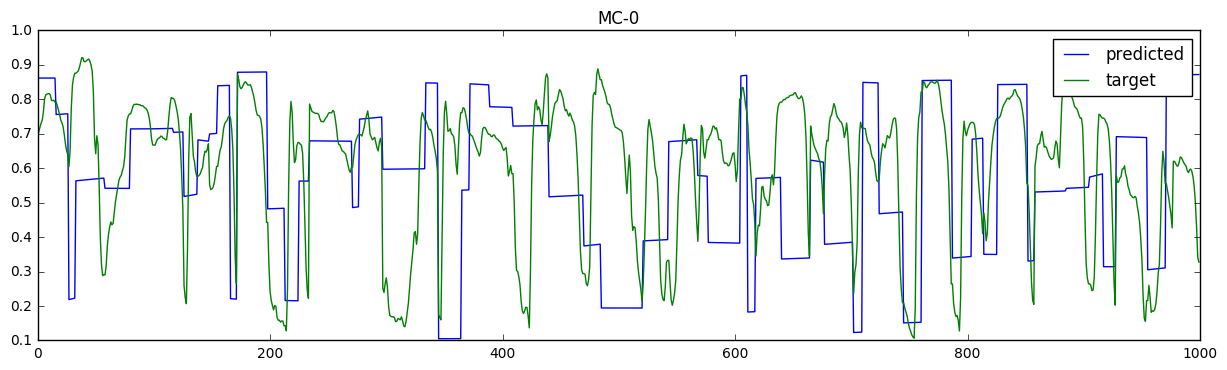

In [118]:
plt.figure(figsize=(15,4))
n=0
plt.title('MC-{}'.format(n))
plt.plot(output_test[0:1000,n],label='predicted')
plt.plot(target_test2[0:1000,n],label='target')
plt.legend()
plt.show()

### Single sentence test

In [120]:
import generate_training_set as gt
data_test = gt.generate_sentence_data(["arctic_a0348","Get down and dig in."])
data_test = np.array(data_test)

arctic_a0348
274


In [121]:
input_test = data_test[:,0:215]
print(input_test.shape)
target_test = data_test[:,216:242]
print(target_test.shape)

input_test2 = (input_test-mean[0:215])/(std[0:215])
target_test2 = (target_test-mins)/(maxs-mins)

(274, 215)
(274, 26)


In [122]:
output_test = []
for test in input_test2:
    test = np.array(test)
    test = test.reshape(1,215)
    output_test.append(model.predict(test).reshape(26))
output_test= np.asarray(output_test)

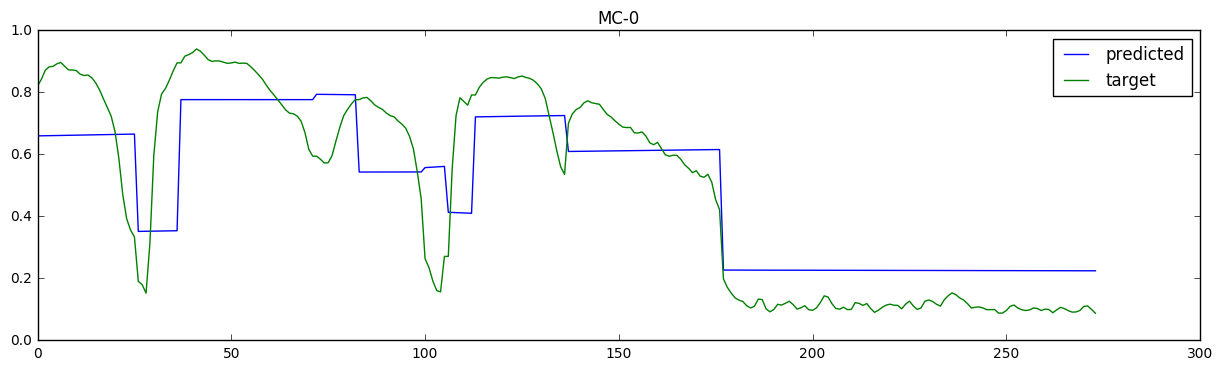

In [123]:
plt.figure(figsize=(15,4))
n=0
plt.title('MC-{}'.format(n))
plt.plot(output_test[0:1000,n],label='predicted')
plt.plot(target_test2[0:1000,n],label='target')
plt.legend()
plt.show()

In [106]:
test_mc = np.array(output_test*(maxs-mins)+mins)#.reshape(len(output_test))
test_mc.shape

(274, 26)

In [107]:
# audio file rate
rate = 16000

# frame data for pitch and mel-cepstrum
window_size = 512
window_step = 80

In [108]:
# order and alpha of mel-cepstrum
order = 25
alpha = 0.41

import pysptk
import librosa
from IPython.display import Audio



from pysptk.synthesis import MLSADF, Synthesizer

#source_excitation = pysptk.excite(test_f0s, 80)
source_excitation = pysptk.excite(data_test[:,215].copy(order='C'), 80)
# Convert mel-cesptrum to MLSADF coefficients
a = np.apply_along_axis(pysptk.mc2b, 1, data_test[:,216:242], alpha);
b = np.apply_along_axis(pysptk.mc2b, 1, test_mc, alpha);

synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), window_step)

mc_synthesized = synthesizer.synthesis(source_excitation, a)
mc_synthesized_pred =synthesizer.synthesis(source_excitation, b)

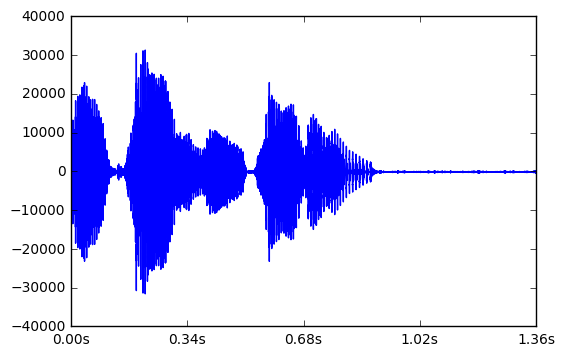

In [109]:
librosa.display.waveplot(mc_synthesized, sr=16000)
Audio(mc_synthesized, rate=16000)

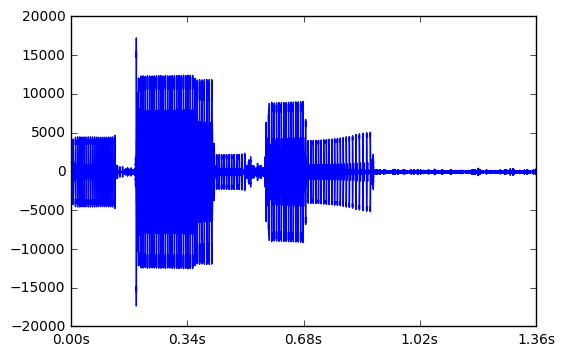

In [110]:
librosa.display.waveplot(mc_synthesized_pred, sr=16000)
Audio(mc_synthesized_pred, rate=16000)